## Stateful LSTM Model for Time Series Prediction
#### Group Project of Information Retrieval and Data Mining 2016 @ UCL

Authors: [Ying Wen](mailto:ying.wen@cs.ucl.ac.uk), Yijing Yang, Xinyi He

This notebook trains a LSTM model for load forcasting on [Global Energy Forecasting Competition 2012](https://www.kaggle.com/c/global-energy-forecasting-competition-2012-load-forecasting) dataset with [Keras](http://keras.io/) and [Theano](http://deeplearning.net/software/theano/).

Except where otherwise noted, this work is subject to a Creative Common Attribution-NonCommercial 4.0 License. [Details.](https://creativecommons.org/licenses/by-nc/4.0/)



In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from load_data import setup_training_data, normalization, de_normalization

Using Theano backend.


### Training and testing data

In our model, we use the data from 01/01/2004 to 23/06/2008 as training set, the data from 24/06/2008 to 30/06/2008 as testing data to evaluate our model's future prediction ability

In [2]:
# inputs_full/inputs: training data from 01/01/2004 to 30/06/2008
# which uses previous week's load to fill missing load data
# mean_load, std_load are used to recover the normalized expected_output and predicted_output
# which are scaled by log and normalized by zero-centered,
# normalization: mean subtraction and divide each dimension by its standard deviation
mean_load, std_load, inputs_full, inputs, expected_output, expected_output_full = setup_training_data()
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 2
epochs = 10
# number of elements ahead that are used to make the prediction
lahead = 1
hidden_size = 100
lstm_layers_num = 3

Loading Data
('Full inputs shape', (39414, 1, 35))
('Full output shape', (39414, 20))
('Input shape:', (39246, 1, 35))
('Output shape', (39246, 20))


In [3]:
print('Creating Model')
model = Sequential()
model.add(LSTM(hidden_size, batch_input_shape=(batch_size, tsteps, inputs.shape[2]),
               return_sequences=True,
               stateful=True))
for i in range(2,lstm_layers_num):
    model.add(LSTM(hidden_size, batch_input_shape=(batch_size, tsteps, hidden_size),
                   return_sequences=True,
                   stateful=True))
model.add(LSTM(hidden_size,
               batch_input_shape=(batch_size, tsteps, hidden_size),
               return_sequences=False,
               stateful=True))
model.add(Dense(expected_output.shape[1]))
model.compile(loss='mse', optimizer='rmsprop')
print(model.summary())

Creating Model
--------------------------------------------------------------------------------
Initial input shape: (2, 1, 35)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
LSTM (lstm)                   (2, 1, 100)                   54400               
LSTM (lstm)                   (2, 1, 100)                   80400               
LSTM (lstm)                   (2, 100)                      80400               
Dense (dense)                 (2, 20)                       2020                
--------------------------------------------------------------------------------
Total params: 217220
--------------------------------------------------------------------------------
None


The architecture of model:

![diagram](./stateful_lstm.jpg)


In [4]:
print('Training')
for i in range(epochs):
    print('Epoch', i+1, '/', epochs)
    model.fit(inputs,
              expected_output,
              batch_size=batch_size,
              verbose=2,
              nb_epoch=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 1 / 10
Epoch 1/1
81s - loss: 0.1083
Epoch 2 / 10
Epoch 1/1
85s - loss: 0.0860
Epoch 3 / 10
Epoch 1/1
88s - loss: 0.0813
Epoch 4 / 10
Epoch 1/1
86s - loss: 0.0774
Epoch 5 / 10
Epoch 1/1
88s - loss: 0.0754
Epoch 6 / 10
Epoch 1/1
89s - loss: 0.0749
Epoch 7 / 10
Epoch 1/1
89s - loss: 0.0724
Epoch 8 / 10
Epoch 1/1
91s - loss: 0.0722
Epoch 9 / 10
Epoch 1/1
89s - loss: 0.0717
Epoch 10 / 10
Epoch 1/1
89s - loss: 0.0706


After the training, we use the trained model to predict the loads of 20 zones from 01/01/2004 to 30/06/2008. 

In [5]:
print('Predicting')
model.reset_states()
predicted_output = model.predict(inputs_full, batch_size=batch_size)
expected_output = de_normalization(mean_load, std_load, expected_output_full, if_log=True)
predicted_output = de_normalization(mean_load, std_load, predicted_output, if_log=True)
print('len for pred:',len(predicted_output))
print('len for expect:',len(expected_output))

Predicting
len for pred: 39414
len for expect: 39414


In [6]:
from plot import plot_by_column, plot_by_row
%matplotlib inline
print('Total prediction numbers',len(predicted_output))
# plot_by_column(benchmark, predicted_output[-1-168:-1], sub_num=20, begin = 0, time_steps = 168)

Total prediction numbers 39414


In [8]:
from sklearn.metrics import mean_squared_error
# calculte the sum load of 20 zones 
temp = np.zeros((len(predicted_output),1))
expected_temp = np.zeros((len(expected_output),1))
for i in range(len(predicted_output)):
    temp[i][0] = np.sum(predicted_output[i])
    expected_temp[i][0] = np.sum(expected_output[i])
predicted_output = np.concatenate((predicted_output,temp),axis=1)
expected_output = np.concatenate((expected_output,expected_temp),axis=1)

rsme: 19231.1699659
Forcasting result from 24/06/2008 - 06/30/2008, and the zone 21 is sum load for 20 zones. 
The blue line for training data, the green line for forcasting data.


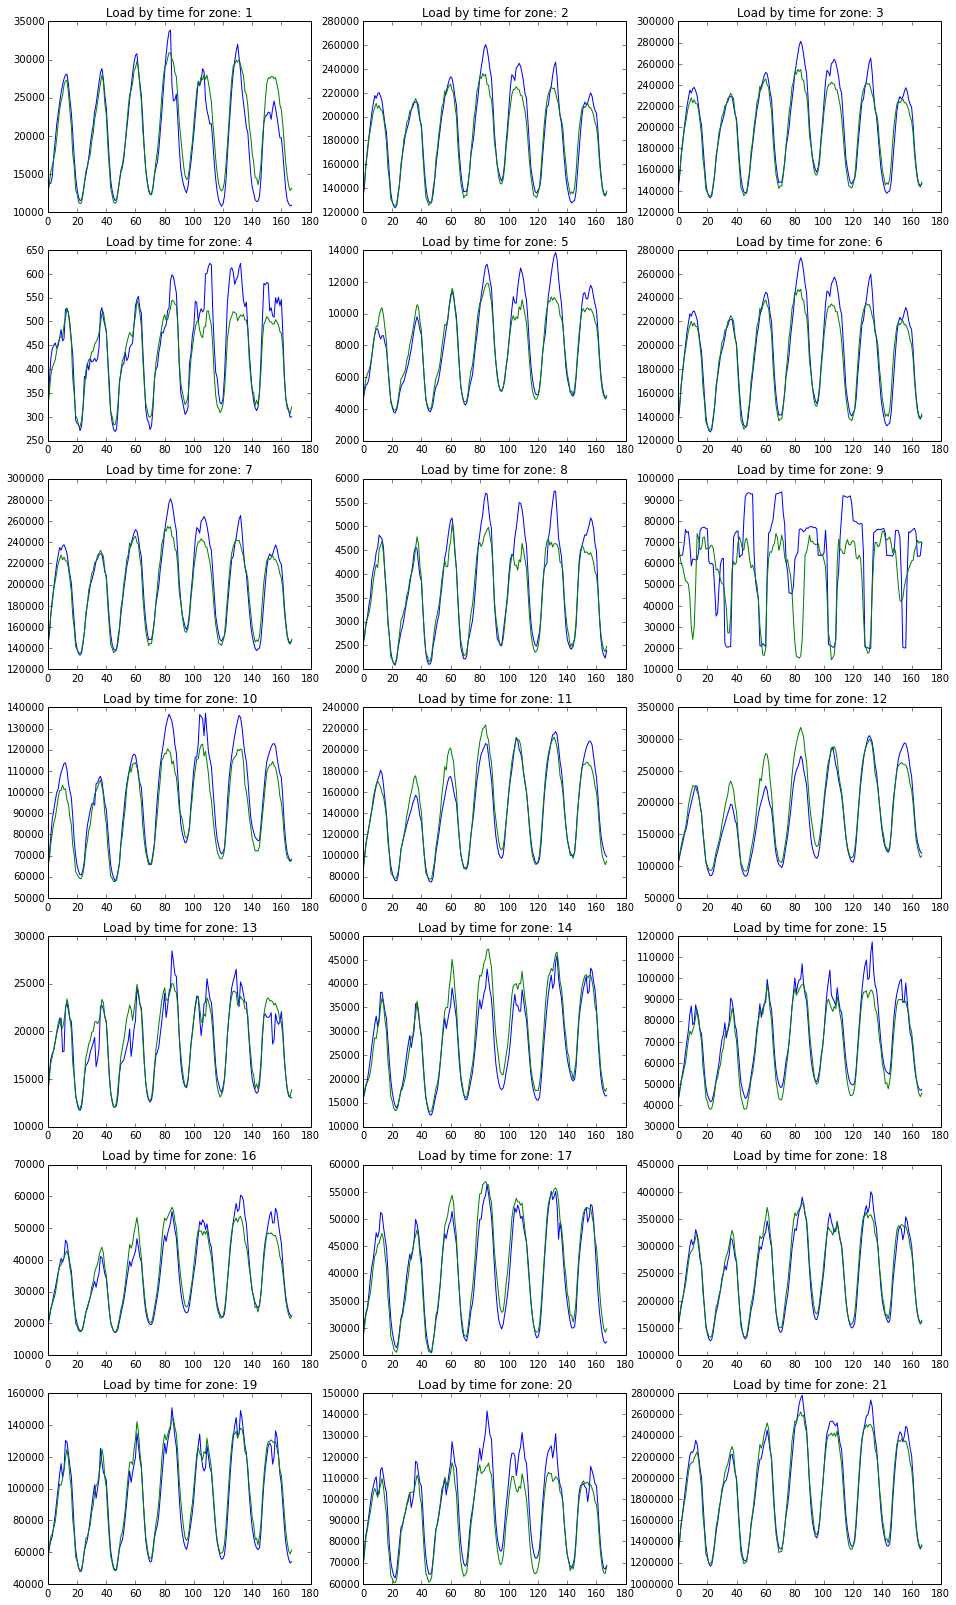

In [9]:
pred_future = predicted_output[-1-168:-1]
expected_future = expected_output[-1-168:-1]
rsme = np.sqrt(mean_squared_error(expected_future, pred_future))
print('rsme:',rsme)
print('Forcasting result from 24/06/2008 - 06/30/2008, and the zone 21 is sum load for 20 zones. ')
print('The blue line for training data, the green line for forcasting data.')
plot_by_column(expected_future, pred_future, sub_num=21, begin = 0, time_steps = 168)

In [10]:
rst_file = open('rsts.log','a')
paramters = {'tsteps':tsteps,
             'batch_size':batch_size,
             'lstm_layers_num':lstm_layers_num,
             'hidden_size':hidden_size, 
             'rsme':rsme,
             'epochs':epochs,
             'inputs':'time;previous_week_load;temperature'}
print(paramters)
rst_file.write(str(paramters)+'\n')
rst_file.close()

{'lstm_layers_num': 3, 'hidden_size': 100, 'rsme': 19231.169965892928, 'batch_size': 2, 'epochs': 10, 'inputs': 'time;previous_week_load;temperature', 'tsteps': 1}


### Fitting and prediction results
The first half in each figure is fitting results from 17/06/2008 to 23/06/2008.

The second half in each figure is forecasting results from 24/06/2008 to 06/30/2008.

Besides, **the zone 21 is sum load of 20 zones**. 

The best **RMSE** of our model is **19,231**, while the baseline **RMSE** by average history is **167,462**, which has achieved great improvement. 

**Note:**

(**The RMSE is calculated on the predicted results of 21 zones from 24/06/2008 - 06/30/2008**)

(The blue line is real expected load, the green line is the load forecasting by our model)

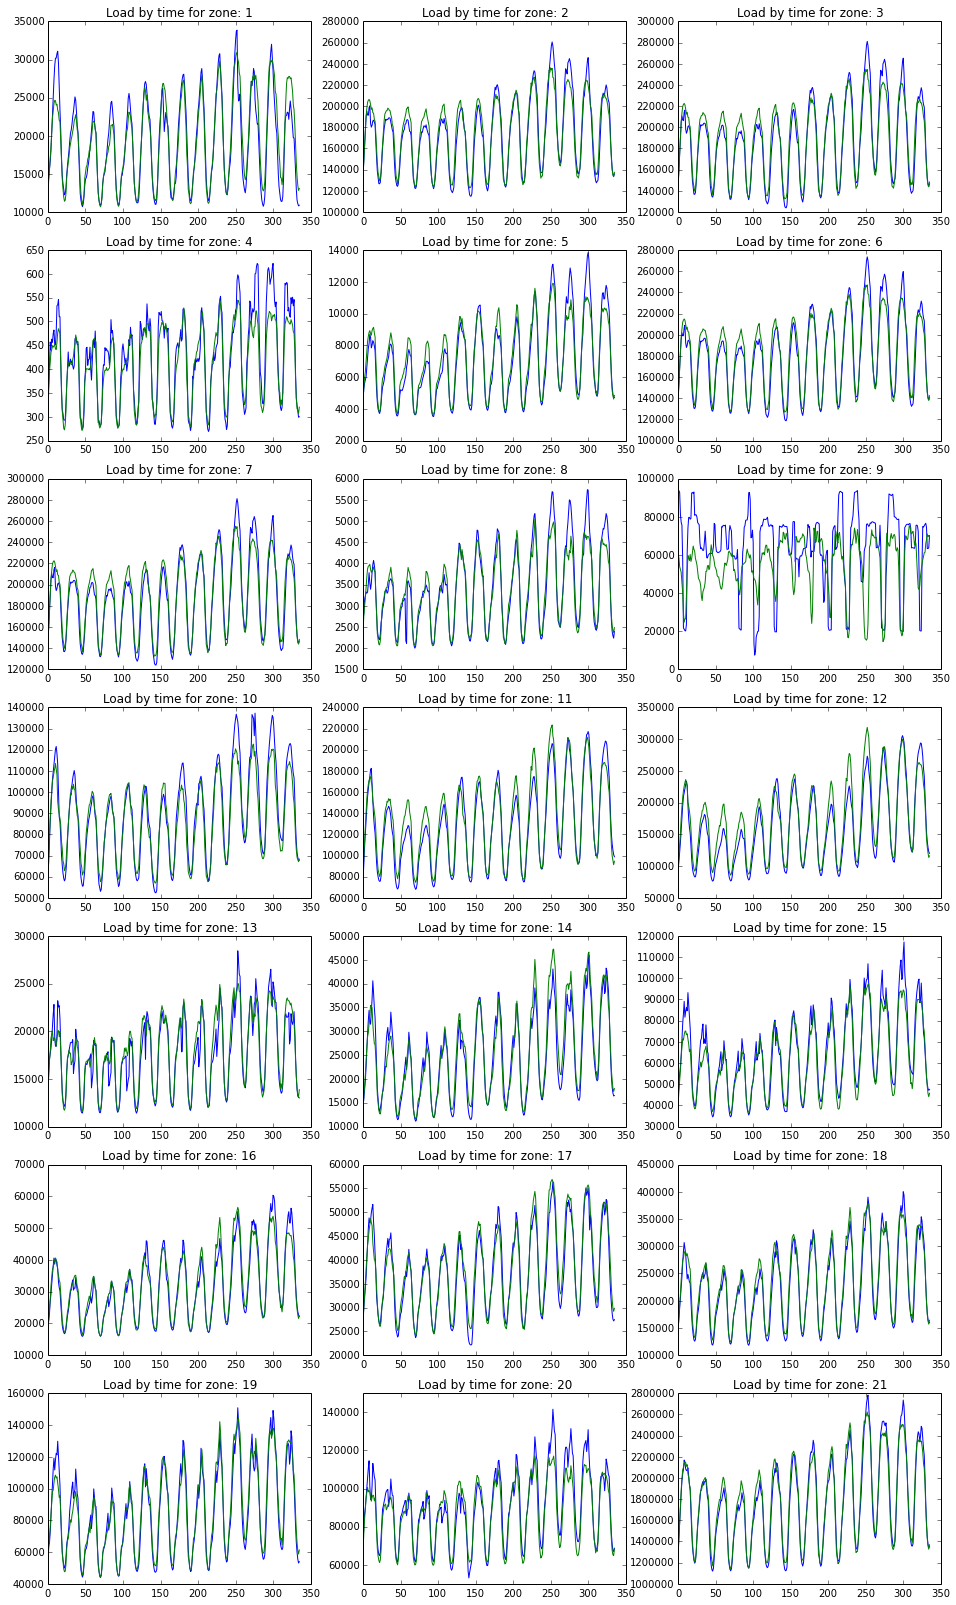

In [11]:
plot_by_column(expected_output, predicted_output, sub_num=21, begin = 39414-168-168-1, time_steps = 168*2)